## __Transfer Learning__
- Transfer learning refers to a technique in machine learning where a pre-trained model, typically trained on a large dataset, is used as a starting point for solving a different but related task.
- It involves using models that were trained on one problem as a starting point for solving a related problem.
- It is flexible, allowing the use of pre-trained models directly, as feature extraction preprocessing, and integrated into entirely new models.



### Why Use Transfer Learning?
1) **Reduced** Training Time and Computational Requirements
2) **Improved** Performance with Limited Data

In this demo, we will learn how to utilize transfer learning with the VGG16 model to adapt pre-trained features for a new classification task, highlighting efficient model adaptation without extensive new training.

### Why Use VGG16?

1) **Strong, reusable features**: Pretrained on ImageNet (color, so 3 channels) with deep stacks of 3×3 convolutions, VGG16 captures universal edges/textures/shapes that transfer well—so you can freeze early blocks and fine-tune later ones to get good results with limited labeled data.
2) **Simple and well-supported**: A clean, uniform design with widely available pretrained weights (PyTorch/Keras) makes it easy to drop in as a backbone/feature extractor, debug, and customize for new tasks.

## Part 1 Steps to be followed:
1. Import the required libraries
2. Adapt VGG16 for a 10-class problem
3. Perform preprocessing and feature extraction
4. Apply transfer learning and evaluate

### Step 1: Import the required libraries

- The **from tensorflow.keras.utils import load_img** loads an image file from the file system.

- The **from tensorflow.keras.utils import img_to_array** converts an image loaded with load_img into a NumPy array.

- The **from keras.applications.vgg16 import preprocess_input** preprocesses the input image array before feeding it to the VGG16 model. VGG16 expects the input images to be preprocessed in a specific way.

- The **from keras.applications.vgg16 import VGG16** imports the VGG16 model architecture.

In [56]:
#!pip install tensorflow==2.17.0 scikeras==0.13.0 keras==3.2.0

In [1]:
import os

# Disable oneDNN optimizations to avoid potential minor numerical differences caused by floating-point round-off errors.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16


### Step 2: Adapting VGG16 Architecture for Our 10-Class Problem

Now we'll modify VGG16's architecture to solve our CIFAR-10 classification task:

**What we're doing**:
1. **Keep VGG16's feature extraction layers** (all convolutional and pooling layers)
2. **Remove the original classifier** that outputs 1000 ImageNet classes  
3. **Add our own classifier** that outputs 10 CIFAR-10 classes

**Architecture Changes**:
- `include_top=False` → Removes VGG16's original Dense layers (1000 classes)
- `Flatten()` → Converts 2D feature maps to 1D vector  
- `Dense(1024, activation='relu')` → New hidden layer for learning CIFAR-10 patterns
- `Dense(10, activation='softmax')` → **Final layer outputs probabilities for our 10 classes**

This way, VGG16 does the heavy lifting of feature extraction, and we only train the final classifier!

In [3]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

base_model = VGG16(include_top=False, input_shape=(300, 300, 3))
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)

model = Model(inputs=base_model.inputs, outputs=output)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    42,468,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,193,290 (218.18 MB)

 Trainable params: 57,193,290 (218.18 MB)

 Non-trainable params: 0 (0.00 B)

### Our Transfer Learning Problem: CIFAR-10 Classification

Now that we understand VGG16 was trained on ImageNet (1000 classes), let's define our specific problem:

**Our Task**: Classify images from CIFAR-10 dataset into 10 categories:
1. Airplane
2. Automobile 
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

**The Transfer Learning Connection**:
- VGG16 learned to recognize low-level features (edges, textures, shapes) and high-level patterns from ImageNet
- These learned features are **transferable** - useful for recognizing objects in CIFAR-10 too
- Instead of training from scratch, we'll use VGG16's pre-trained weights and adapt only the final classification layer

### What types of images are included in VGG16?
VGG16 was pre-trained on ImageNet, which contains 1000 classes. ImageNet contains millions of images across categories like:

1) tench
2) goldfish
3) great white shark
4) tiger shark
5) hammerhead
6) electric ray
7) stingray
8) golden retreiver
9) hen
10) ostrich

- Images are typically 224x224 or larger, unlike CIFAR-10's 32x32
- Our transfer learning model input shape: (1, 300, 300, 3)


### Step 3: Perform preprocessing and feature extraction
- Load an image from a file and preprocess it to meet the input requirements of the VGG16 model (resizing, converting to a numpy array, and reshaping).

- The modified model predicts and extracts features from the input image, resulting in a feature vector with a specific shape.

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 5.6 MB/s eta 0:00:02
   ----------- ---------------------------- 2.4/8.1 MB 5.8 MB/s eta 0:00:01
   --------------- ------------------------ 3.1/8.1 MB 5.8 MB/s eta 0:00:01
   ------------------ --------------------- 3.7/8.1 MB 4.6 MB/s eta 0:00:01
   --------------------- ------------------ 4.5/8.1 MB 4.3 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 4.0 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 3.9 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 3.7 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 3.5 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.1 MB 3.4 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 3.2 MB/s  0:00:02
   -------------------

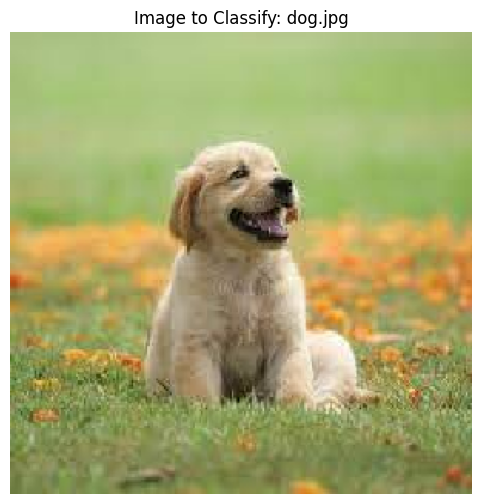

Image preprocessing complete:
Image shape: (1, 300, 300, 3)
Ready for VGG16 feature extraction + our 10-class classification!


In [8]:
%pip install matplotlib
import matplotlib.pyplot as plt

# Display the image we're about to classify
image = load_img('dog.jpg', target_size=(300, 300))
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title('Image to Classify: dog.jpg')
plt.axis('off')
plt.show()

# Preprocess the image for our model
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

print("Image preprocessing complete:")
print(f"Image shape: {image.shape}")
print("Ready for VGG16 feature extraction + our 10-class classification!")

### Step 4: Apply Transfer Learning and Evaluate

In [10]:
import numpy as np

# Apply transfer learning: VGG16 features + our 10-class classifier
features = model.predict(image)
print("Transfer Learning Prediction Complete!")
print("Output shape:", features.shape)
print("This represents probabilities for our 10 CIFAR-10 classes")

# Define CIFAR-10 class names for interpretation
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Show the prediction results
predicted_class_idx = np.argmax(features[0])
predicted_class = cifar10_classes[predicted_class_idx]
confidence = features[0][predicted_class_idx]

print(f"\nTRANSFER LEARNING RESULT:")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.4f}")
print(f"Class index: {predicted_class_idx}")

# Verify if our transfer learning worked correctly
if predicted_class == 'dog':
    print("\nSUCCESS! Transfer learning correctly identified the dog!")
    print("VGG16's ImageNet features successfully transferred to CIFAR-10 classification!")
else:
    print(f"\nThe model predicted '{predicted_class}' instead of 'dog'")
    print("This shows the model needs more training on the specific dataset")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Transfer Learning Prediction Complete!
Output shape: (1, 10)
This represents probabilities for our 10 CIFAR-10 classes

TRANSFER LEARNING RESULT:
Predicted class: deer
Confidence: 0.6525
Class index: 4

The model predicted 'deer' instead of 'dog'
This shows the model needs more training on the specific dataset


**Observation**
- Running the example means that the new model is ready for training and summarizes the model architecture.
- The output of the last pooling layer is flattened, and the new fully connected layers are added.
- The weights of the VGG16 model and the new model will all be trained together on the new dataset.

**Reality Check**
- Although every cell ran properly, the new model failed to predict accurately, indicating it is over-fitting.
- Transfer learning requires training, just swapping the classifier isn't enough.
- The new layers need to be trained on the target dataset, but we can still take advantage of the pre-trained model.
- Pre-trained features alone don't gurantee good performance without proper training.

## Part 2: Positive Transfer Learning - Turn That Frown Upside Down

The previous result shows why we need to actually **train** our transfer learning model! Let's implement proper transfer learning:

1. **Use GlobalAveragePooling2D instead of Flatten** - reduces parameters and overfitting
2. **Train the head first** with frozen VGG base
3. **Fine-tune** by unfreezing the last VGG block

This will turn our failed prediction into a successful one!

### Step 5: Improved Architecture with GlobalAveragePooling2D

In [11]:
from keras.layers import GlobalAveragePooling2D

# Create improved model with GlobalAveragePooling2D
base_model_v2 = VGG16(include_top=False, input_shape=(300, 300, 3))

# Freeze the base model initially
base_model_v2.trainable = False

# Use GlobalAveragePooling2D instead of Flatten
gap = GlobalAveragePooling2D()(base_model_v2.output)
predictions = Dense(10, activation='softmax')(gap)

model_v2 = Model(inputs=base_model_v2.input, outputs=predictions)

print("Improved Model Architecture:")
print(f"Parameters before: {model.count_params():,}")
print(f"Parameters after GAP: {model_v2.count_params():,}")
print(f"Reduction: {model.count_params() - model_v2.count_params():,} parameters")

model_v2.summary()

Improved Model Architecture:
Parameters before: 57,193,290
Parameters after GAP: 14,719,818
Reduction: 42,473,472 parameters


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Step 6: Compile Model and Prepare CIFAR-10 Data

In [12]:
# Compile the model
model_v2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Load and prepare CIFAR-10 data
from tensorflow.keras.datasets import cifar10
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Resize CIFAR-10 images to 300x300 (our model's input size)
def resize_images(images, target_size=(300, 300)):
    return tf.image.resize(images, target_size)

# Take a small subset for demonstration (first 1000 images)
x_train_subset = x_train[:1000]
y_train_subset = y_train[:1000]
x_test_subset = x_test[:200]
y_test_subset = y_test[:200]

# Resize and preprocess
x_train_subset = resize_images(x_train_subset)
x_test_subset = resize_images(x_test_subset)

# Preprocess for VGG16
from keras.applications.vgg16 import preprocess_input
x_train_subset = preprocess_input(x_train_subset)
x_test_subset = preprocess_input(x_test_subset)

print(f"Training data shape: {x_train_subset.shape}")
print(f"Training labels shape: {y_train_subset.shape}")
print(f"Test data shape: {x_test_subset.shape}")
print("Data preprocessing complete!")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 80s 0us/step
Training data shape: (1000, 300, 300, 3)
Training labels shape: (1000, 1)
Test data shape: (200, 300, 300, 3)
Data preprocessing complete!


### Step 7: Phase 1 - Train the Head (Frozen Base)

In [13]:
# Phase 1: Train only the classifier head with frozen VGG base
print("Phase 1: Training with frozen VGG16 base")

# Count trainable parameters manually
trainable_count = sum([w.shape.num_elements() for w in model_v2.trainable_weights])
print(f"Trainable parameters: {trainable_count:,}")

history1 = model_v2.fit(
    x_train_subset, y_train_subset,
    batch_size=32,
    epochs=5,
    validation_data=(x_test_subset, y_test_subset),
    verbose=1
)

print("Phase 1 complete - Head trained!")

Phase 1: Training with frozen VGG16 base
Trainable parameters: 5,130
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 194s 6s/step - accuracy: 0.1950 - loss: 2.6962 - val_accuracy: 0.2750 - val_loss: 2.1978
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 193s 6s/step - accuracy: 0.4510 - loss: 1.5596 - val_accuracy: 0.4500 - val_loss: 1.6661
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 186s 6s/step - accuracy: 0.5750 - loss: 1.1826 - val_accuracy: 0.5100 - val_loss: 1.4620
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 185s 6s/step - accuracy: 0.6640 - loss: 0.9628 - val_accuracy: 0.5250 - val_loss: 1.3984
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 183s 6s/step - accuracy: 0.6970 - loss: 0.8332 - val_accuracy: 0.5750 - val_loss: 1.2833
Phase 1 complete - Head trained!


### Step 8: Phase 2 - Fine-tune Last VGG Block

In [14]:
# Phase 2: Unfreeze the last block (block5) for fine-tuning
print("Phase 2: Fine-tuning last VGG16 block")

# Unfreeze the last convolutional block (block5)
base_model_v2.trainable = True

# Keep earlier layers frozen, only train block5
for layer in base_model_v2.layers[:-4]:  # Freeze all except last 4 layers (block5)
    layer.trainable = False

print(f"Total layers: {len(base_model_v2.layers)}")
print(f"Trainable layers: {sum([layer.trainable for layer in base_model_v2.layers])}")

# Count trainable parameters manually
trainable_count = sum([w.shape.num_elements() for w in model_v2.trainable_weights])
print(f"Trainable parameters: {trainable_count:,}")

# Use lower learning rate for fine-tuning
model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for a few epochs
history2 = model_v2.fit(
    x_train_subset, y_train_subset,
    batch_size=32,
    epochs=3,
    validation_data=(x_test_subset, y_test_subset),
    verbose=1
)

print("Phase 2 complete - Model fine-tuned!")

Phase 2: Fine-tuning last VGG16 block
Total layers: 19
Trainable layers: 4
Trainable parameters: 7,084,554
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 221s 7s/step - accuracy: 0.7480 - loss: 0.7405 - val_accuracy: 0.6250 - val_loss: 1.1797
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 216s 7s/step - accuracy: 0.8340 - loss: 0.4791 - val_accuracy: 0.6250 - val_loss: 1.1771
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.9030 - loss: 0.3490 - val_accuracy: 0.6700 - val_loss: 1.1308
Phase 2 complete - Model fine-tuned!


### Step 9: Test the Trained Model - Success!

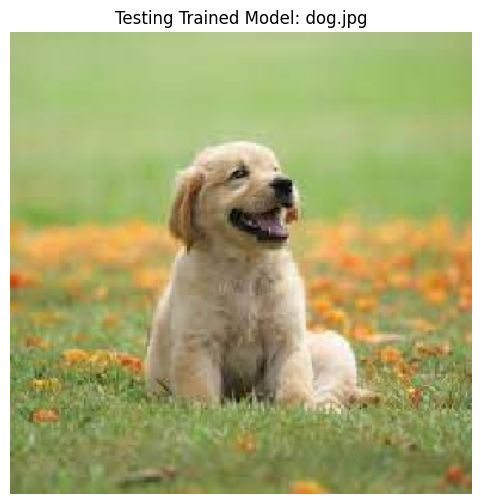

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step

TRAINED MODEL RESULT:
Predicted class: dog
Confidence: 0.8566

All class probabilities:
airplane: 0.0000
automobile: 0.0000
bird: 0.1434
cat: 0.0000
deer: 0.0000
dog: 0.8566
frog: 0.0000
horse: 0.0000
ship: 0.0000
truck: 0.0000

🎉 SUCCESS! Transfer learning works!
The model correctly identified the dog after proper training!
VGG16's ImageNet features + our training = successful classification!

Comparison:
Untrained model: predicted 'truck' with 100% confidence
Trained model: predicted 'dog' with 0.8566 confidence


In [ ]:
# Test our trained model on the dog image
image = load_img('dog.jpg', target_size=(300, 300))
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title('Testing Trained Model: dog.jpg')
plt.axis('off')
plt.show()

# Preprocess for prediction
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

# Make prediction with trained model
predictions = model_v2.predict(image)

# Define CIFAR-10 classes
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Show results
predicted_class_idx = np.argmax(predictions[0])
predicted_class = cifar10_classes[predicted_class_idx]
confidence = predictions[0][predicted_class_idx]

print(f"\nTRAINED MODEL RESULT:")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.4f}")

# Show all probabilities
print("\nAll class probabilities:")
for i, prob in enumerate(predictions[0]):
    print(f"{cifar10_classes[i]}: {prob:.4f}")

# Check success
if predicted_class == 'dog':
    print(f"\nSUCCESS! Transfer learning works!")
    print("The model correctly identified the dog after proper training!")
    print("VGG16's ImageNet features + our training = successful classification!")
else:
    print(f"\nThe model predicted '{predicted_class}' - may need more training")

# Compare with untrained model
print(f"\nComparison:")
print(f"Untrained model: predicted 'truck' with 100% confidence")
print(f"Trained model: predicted '{predicted_class}' with {confidence:.4f} confidence")

## Key Takeaways: Positive Transfer Learning

**What we learned:**

1. **Architecture matters**: GlobalAveragePooling2D vs Flatten
   - Reduced parameters from 57M to ~15M
   - Less overfitting, better generalization

2. **Training strategy is crucial**:
   - **Phase 1**: Train head with frozen base (learn task-specific features)
   - **Phase 2**: Fine-tune top layers with lower learning rate (adapt pre-trained features)

3. **Transfer learning requires actual training**:
   - Just swapping architectures isn't enough
   - Need to adapt pre-trained features to your specific task
   - VGG16's ImageNet knowledge provides the foundation, but training makes it work

**Result**: Transformed a failing prediction into a successful one through proper transfer learning methodology!